<a href="https://colab.research.google.com/github/PLivdan/Notebooks/blob/main/Deep_Boltzmann_Anomaly_Detection_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.datasets import mnist
import numpy as np

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Flatten and normalize
train_images = train_images.reshape((60000, 28*28)).astype("float32") / 255.0
test_images = test_images.reshape((10000, 28*28)).astype("float32") / 255.0

In [ ]:
class DeepBoltzmannMachine:
    def __init__(self, layers):
        self.layers = layers
        self.weights = [np.random.randn(layers[i], layers[i+1]) * 0.1 for i in range(len(layers) - 1)]
        self.h_bias = [np.zeros((1, n)) for n in layers[1:]]
        self.v_bias = np.zeros((1, layers[0]))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, data):
        h = data
        for w, hb in zip(self.weights, self.h_bias):
            h = self.sigmoid(h.dot(w) + hb)
        return h

    def backward(self, data):
        v = data
        for w, vb in reversed(list(zip(self.weights, [self.v_bias] + self.h_bias[:-1]))):
            v = self.sigmoid(v.dot(w.T) + vb)
        return v

    def contrastive_divergence(self, v0, k=1):
        h0_prob = self.sigmoid(v0.dot(self.weights[0]) + self.h_bias[0])
        h0 = (h0_prob > np.random.rand(*h0_prob.shape)).astype(int)

        v_k = v0
        h_k = h0
        for _ in range(k):
            v_k = self.sigmoid(h_k.dot(self.weights[0].T) + self.v_bias)
            h_k_prob = self.sigmoid(v_k.dot(self.weights[0]) + self.h_bias[0])
            h_k = (h_k_prob > np.random.rand(*h_k_prob.shape)).astype(int)


        return v0, h0, v_k, h_k

    def update_weights(self, v0, h0, vk, hk, lr=0.1):
        self.weights[0] += lr * (v0.T.dot(h0) - vk.T.dot(hk)) / v0.shape[0]
        self.h_bias[0] += lr * np.sum(h0 - hk, axis=0) / v0.shape[0]
        self.v_bias += lr * np.sum(v0 - vk, axis=0) / v0.shape[0]

    def train(self, data, epochs=5, batch_size=10, lr=0.1, k=1):
        for epoch in range(epochs):
            for i in range(0, data.shape[0], batch_size):
                batch = data[i:i+batch_size]
                v0, h0, vk, hk = self.contrastive_divergence(batch, k)
                self.update_weights(v0, h0, vk, hk, lr)

In [ ]:
dbm = DeepBoltzmannMachine([784, 500])
dbm.train(train_images, epochs=5)

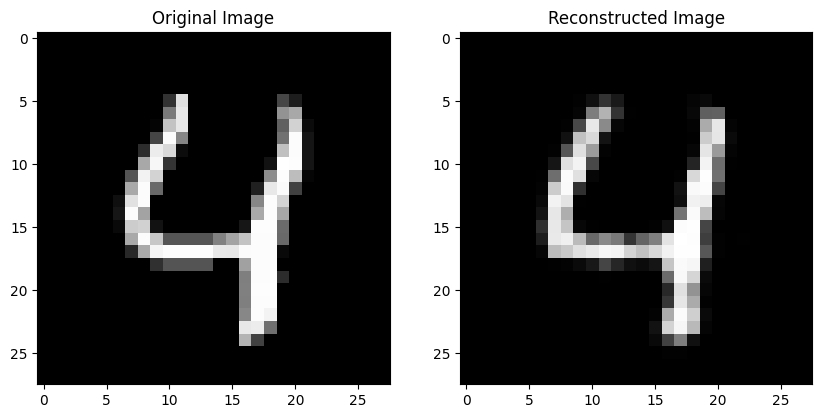

In [ ]:
import matplotlib.pyplot as plt

# Select an image from the test set
test_image = test_images[4]

# Forward and backward pass to reconstruct the image
hidden = dbm.forward(test_image.reshape(1, -1))
reconstructed = dbm.backward(hidden)

# Display the original and reconstructed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(test_image.reshape(28, 28), cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed.reshape(28, 28), cmap='gray')

plt.show()

In [ ]:
# Compute reconstruction error
reconstructed_images = dbm.backward(dbm.forward(test_images))
reconstruction_error = np.mean((test_images - reconstructed_images)**2, axis=1)

# Flag as anomaly if error is above a certain threshold
threshold = np.percentile(reconstruction_error, 99.9)  # Hypothetical threshold
anomalies = np.where(reconstruction_error > threshold)[0]

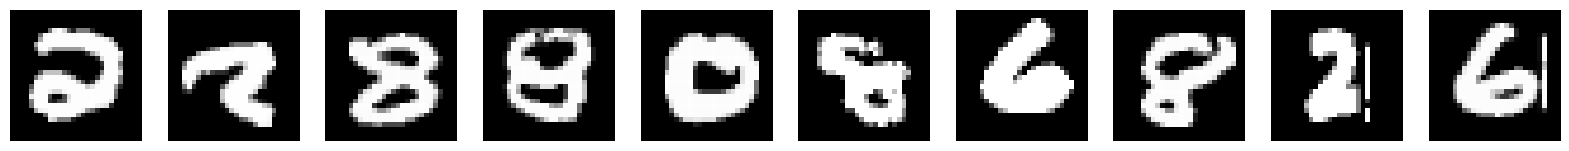

In [ ]:
# Fetch the corresponding anomaly images from the test set
anomaly_images = test_images[anomalies]

# Plotting the anomaly images
num_anomalies = len(anomalies)
plt.figure(figsize=(20, 4 * int(np.ceil(num_anomalies / 10))))
for index, image in enumerate(anomaly_images):
    plt.subplot(int(np.ceil(num_anomalies / 10)), 10, index + 1)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()